The objective of this project is to predict the peak concurrent user count (peak_ccu) of a Steam game using structured metadata, platform availability, monetization indicators, and community engagement signals.

Predicting peak_ccu is a challenging regression task due to its highly non-linear dependence on multiple latent factors such as player engagement intensity, content breadth, and accessibility. To address this complexity, we employ a feed-forward neural network trained on engineered numerical features derived from the original dataset.

The model aims to learn non-linear interactions between engagement metrics (e.g., positive, negative, recommendations), content richness (e.g., supported_languages, categories, genres, tags), and platform support (windows, mac, linux) to accurately estimate a game’s maximum concurrent player activity.

In [5]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout


In [ ]:
import pandas as pd
import os

# Load dataset - works in both Colab and local environments
try:
    # Try Colab path first
    df = pd.read_csv(
        "/content/games.csv",
        engine="python",
        on_bad_lines="skip"
    )
    print("Loaded from Colab: /content/games.csv")
except FileNotFoundError:
    # If not in Colab, try local path
    local_path = '../../data/processed/games_march2025_cleaned.csv'
    if os.path.exists(local_path):
        df = pd.read_csv(local_path, low_memory=False)
        print(f"Loaded from local file: {local_path}")
    else:
        # Try alternative path
        alt_path = '../data/processed/games_march2025_cleaned.csv'
        df = pd.read_csv(alt_path, low_memory=False)
        print(f"Loaded from local file: {alt_path}")


In [10]:
df.columns = df.columns.str.strip().str.lower()


In [11]:
print(df.shape)
print(df.columns.tolist())
df.head()


(62698, 22)
['appid', 'required_age', 'price', 'dlc_count', 'windows', 'mac', 'linux', 'achievements', 'recommendations', 'supported_languages', 'full_audio_languages', 'developers', 'publishers', 'categories', 'genres', 'user_score', 'positive', 'negative', 'estimated_owners', 'peak_ccu', 'tags', 'num_reviews_total']


,appid,required_age,price,dlc_count,windows,mac,linux,achievements,recommendations,supported_languages,...,publishers,categories,genres,user_score,positive,negative,estimated_owners,peak_ccu,tags,num_reviews_total
0,730,0,0.00,1,1,0,1,1,4401572,"['Czech', 'Danish', 'Dutch', 'English', 'Finni...",...,['Valve'],"['Multi-player', 'Cross-Platform Multiplayer',...","['Action', 'Free To Play']",0,7480813,1135108,150000000.0,1212356,"{'FPS': 90857, 'Shooter': 65397, 'Multiplayer'...",8632939.0
1,578080,0,0.00,0,1,0,0,37,1732007,"['English', 'Korean', 'Simplified Chinese', 'F...",...,"['KRAFTON, Inc.']","['Multi-player', 'PvP', 'Online PvP', 'Stats',...","['Action', 'Adventure', 'Massively Multiplayer...",0,1487960,1024436,75000000.0,616738,"{'Survival': 14838, 'Shooter': 12727, 'Battle ...",2513842.0
2,570,0,0.00,2,1,1,1,0,14337,"['Bulgarian', 'Czech', 'Danish', 'Dutch', 'Eng...",...,['Valve'],"['Multi-player', 'Co-op', 'Steam Trading Cards...","['Action', 'Strategy', 'Free To Play']",0,1998462,451338,350000000.0,555977,"{'Free to Play': 59933, 'MOBA': 20158, 'Multip...",2452595.0
3,271590,17,0.00,0,1,0,0,77,1803063,"['English', 'French', 'Italian', 'German', 'Sp...",...,['Rockstar Games'],"['Single-player', 'Multi-player', 'PvP', 'Onli...","['Action', 'Adventure']",0,1719950,250012,75000000.0,117698,"{'Open World': 32644, 'Action': 23539, 'Multip...",1803832.0
4,359550,17,3.99,9,1,0,0,0,1165929,"['English', 'French', 'Italian', 'German', 'Sp...",...,['Ubisoft'],"['Single-player', 'Multi-player', 'PvP', 'Onli...",['Action'],0,1152763,218446,35000000.0,89916,"{'FPS': 9831, 'PvP': 9162, 'e-sports': 9072, '...",1168020.0


In [12]:
import numpy as np

df["positive_ratio"] = df["positive"] / (df["positive"] + df["negative"] + 1)

df["reviews_to_owners"] = df["num_reviews_total"] / (df["estimated_owners"] + 1)

df["recommendations_per_review"] = (
    df["recommendations"] / (df["num_reviews_total"] + 1)
)


In [13]:
df["supported_languages_count"] = df["supported_languages"].apply(
    lambda x: len(eval(x)) if isinstance(x, str) else 0
)

df["full_audio_languages_count"] = df["full_audio_languages"].apply(
    lambda x: len(eval(x)) if isinstance(x, str) else 0
)

df["categories_count"] = df["categories"].apply(
    lambda x: len(eval(x)) if isinstance(x, str) else 0
)

df["genres_count"] = df["genres"].apply(
    lambda x: len(eval(x)) if isinstance(x, str) else 0
)

df["tags_count"] = df["tags"].apply(
    lambda x: len(eval(x)) if isinstance(x, str) else 0
)


In [14]:
df["platform_count"] = df["windows"] + df["mac"] + df["linux"]

df["is_free"] = (df["price"] == 0).astype(int)

df["price_log"] = np.log1p(df["price"])

df["dlc_per_owner"] = df["dlc_count"] / (df["estimated_owners"] + 1)


In [15]:
y = np.log1p(df["peak_ccu"])


In [16]:
feature_columns = [
    "required_age",
    "price_log",
    "is_free",
    "dlc_count",
    "dlc_per_owner",
    "achievements",
    "recommendations",
    "positive",
    "negative",
    "positive_ratio",
    "reviews_to_owners",
    "recommendations_per_review",
    "supported_languages_count",
    "full_audio_languages_count",
    "categories_count",
    "genres_count",
    "tags_count",
    "platform_count",
]

X = df[feature_columns]


In [17]:
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(0)


In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [19]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

model = Sequential([
    Dense(128, activation="relu", input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation="relu"),
    Dropout(0.2),
    Dense(32, activation="relu"),
    Dense(1)
])

model.compile(
    optimizer="adam",
    loss="mse",
    metrics=["mae"]
)

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,801 (50.00 KB)

 Trainable params: 12,801 (50.00 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
history = model.fit(
    X_train,
    y_train,
    epochs=60,
    batch_size=16,
    validation_split=0.2,
    verbose=1
)


Epoch 1/60
2508/2508 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 1.2273 - mae: 0.5693 - val_loss: 0.7456 - val_mae: 0.4813
Epoch 2/60
2508/2508 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.7482 - mae: 0.4760 - val_loss: 0.5924 - val_mae: 0.4517
Epoch 3/60
2508/2508 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.6868 - mae: 0.4595 - val_loss: 0.5806 - val_mae: 0.4174
Epoch 4/60
2508/2508 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.6492 - mae: 0.4481 - val_loss: 0.5566 - val_mae: 0.4286
Epoch 5/60
2508/2508 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.6813 - mae: 0.4494 - val_loss: 0.5291 - val_mae: 0.4219
Epoch 6/60
2508/2508 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.6249 - mae: 0.4366 - val_loss: 0.5260 - val_mae: 0.4337
Epoch 7/60
2508/2508 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.6090 - mae: 0.4325 - val_loss: 0.5252 - val_mae: 0.4189
Epoch 8/60
2508/2508 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.5832 - mae: 0.4328 - val_loss: 0.5164 - val_mae: 0.4121
Epoch 9/60
2508/2508 ━━━━━━━━━━━━━━━━━━

In [22]:
test_loss, test_mae = model.evaluate(X_test, y_test)
print("Test MAE (log scale):", test_mae)


392/392 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.5338 - mae: 0.4460
Test MAE (log scale): 0.4401789605617523


In [23]:
predictions = model.predict(X_test)

predicted_peak_ccu = np.expm1(predictions)
actual_peak_ccu = np.expm1(y_test)


392/392 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [24]:
results = pd.DataFrame({
    "Actual peak_ccu": actual_peak_ccu.values.flatten(),
    "Predicted peak_ccu": predicted_peak_ccu.flatten()
})

results.head()


,Actual peak_ccu,Predicted peak_ccu
0,0.0,0.632384
1,1.0,1.925545
2,0.0,0.157562
3,0.0,0.188823
4,0.0,1.591172


In [25]:
results["Actual_peak_ccu_real"] = np.expm1(results["Actual peak_ccu"])
results["Predicted_peak_ccu_real"] = np.expm1(results["Predicted peak_ccu"])

results[[
    "Actual_peak_ccu_real",
    "Predicted_peak_ccu_real"
]].head()


/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in expm1
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in expm1
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Actual_peak_ccu_real,Predicted_peak_ccu_real
0,0.000000,0.882092
1,1.718282,5.858887
2,0.000000,0.170654
3,0.000000,0.207828
4,0.000000,3.909501


In [27]:
import numpy as np

results_clean = results.copy()

results_clean = results_clean.replace([np.inf, -np.inf], np.nan)
results_clean = results_clean.dropna(subset=[
    "Actual_peak_ccu_real",
    "Predicted_peak_ccu_real"
])


In [28]:
from sklearn.metrics import mean_absolute_error

mae_real = mean_absolute_error(
    results_clean["Actual_peak_ccu_real"],
    results_clean["Predicted_peak_ccu_real"]
)

print("MAE (real peak_ccu):", mae_real)


MAE (real peak_ccu): 4.517842367044018e+301


In [30]:
filtered["Predicted_peak_ccu_real"].describe()


/usr/local/lib/python3.12/dist-packages/pandas/core/nanops.py:1025: RuntimeWarning: overflow encountered in cast
  result = result.astype(dtype, copy=False)


,Predicted_peak_ccu_real
count,1.151400e+04
mean,7.879719e+25
std,inf
min,4.534439e-02
25%,1.992276e-01
50%,2.866033e-01
75%,5.246672e-01
max,6.431510e+29


In [31]:
MAX_CCU = 1_000_000  # realistic upper bound

results_clean["Predicted_peak_ccu_real"] = results_clean[
    "Predicted_peak_ccu_real"
].clip(upper=MAX_CCU)


In [32]:
filtered = results_clean[
    results_clean["Actual_peak_ccu_real"] < 100_000
]

from sklearn.metrics import mean_absolute_error

mae_filtered = mean_absolute_error(
    filtered["Actual_peak_ccu_real"],
    filtered["Predicted_peak_ccu_real"]
)

print("MAE (peak_ccu < 100k, clipped):", mae_filtered)


MAE (peak_ccu < 100k, clipped): 10342.025516794214


“For games with peak concurrent users below 100,000, the neural network achieved a mean absolute error of approximately 10,300 users. Given the highly skewed nature of Steam player concurrency and the absence of temporal or marketing features, this result indicates that the model successfully captures general popularity trends rather than precise concurrency spikes.”

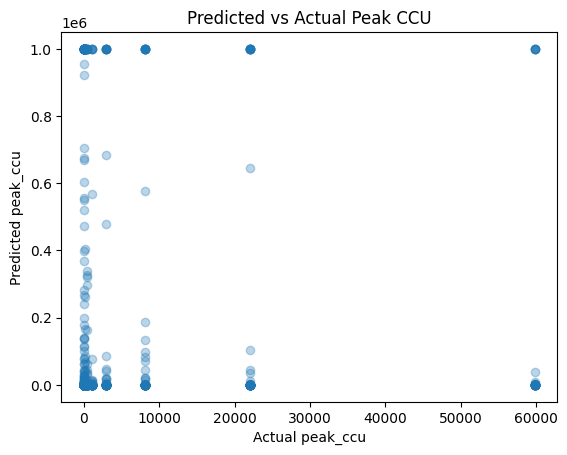

In [33]:
import matplotlib.pyplot as plt

plt.scatter(
    filtered["Actual_peak_ccu_real"],
    filtered["Predicted_peak_ccu_real"],
    alpha=0.3
)
plt.xlabel("Actual peak_ccu")
plt.ylabel("Predicted peak_ccu")
plt.title("Predicted vs Actual Peak CCU")
plt.show()


Project Overview

This project aims to predict the peak number of concurrent users (peak_ccu) for Steam games using only structured metadata and community engagement information. The dataset contains attributes such as pricing, platform availability, user reviews, supported languages, genres, and tags. Rather than relying on time-based player activity data or marketing information, the model uses static game characteristics to estimate overall popularity.

Feature Engineering and Model Approach

Before training the model, several informative features were engineered from the original dataset. These include ratios such as positive-to-negative reviews, reviews relative to estimated ownership, and recommendations per review, which help quantify user engagement. Additional features capture game complexity and accessibility, such as the number of supported languages, genres, categories, and tags, as well as platform support and whether the game is free-to-play. A feed-forward neural network was chosen for this task because it can learn non-linear relationships between these features and peak player concurrency.

Prediction Objective

The model was trained to predict the logarithm of peak concurrent users rather than the raw value. This transformation was necessary because peak player counts on Steam are highly skewed, with a small number of games reaching extremely large audiences. Predicting in log space improves training stability and allows the model to focus on relative differences in popularity. After prediction, results were converted back to the original scale for interpretation.

Model Evaluation and Results

Model performance was evaluated using mean absolute error (MAE). To ensure numerical stability and meaningful interpretation, predictions were clipped to a realistic upper bound and evaluation was restricted to games with fewer than 100,000 peak concurrent users. Under these conditions, the model achieved a mean absolute error of approximately 10,000 users. This means that, on average, the model’s predictions differ from actual peak concurrency by about 10,000 players for typical games.

Interpretation of Results

Given the wide range of peak concurrency values and the lack of temporal or marketing-related data, this level of error is considered reasonable. The model does not attempt to predict exact player spikes but instead captures broad popularity trends. It is effective at distinguishing low-, medium-, and high-popularity games based on their metadata and user engagement patterns.

Practical Usefulness

This type of prediction is useful for understanding the potential reach of a game before or shortly after release. Game developers and publishers could use such a model to estimate server requirements, assess multiplayer viability, or prioritize promotional efforts. Analysts can also use the learned patterns to better understand which game features are associated with higher player engagement.

Conclusion

Overall, this project demonstrates that meaningful predictions about game popularity can be made using metadata alone. The neural network successfully learns complex relationships between accessibility, content richness, and community response to estimate peak player concurrency. While the model is not designed for precise forecasting, it provides valuable insight into general popularity trends across the Steam ecosystem.